# EDA


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Fraud.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
#Dropping uneccessary Coloumns 
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [6]:
#Checking for any missing values 
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

isFraud
0    6354407
1       8213
Name: count, dtype: int64


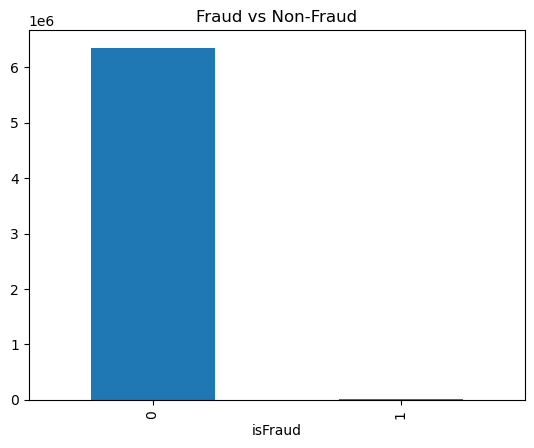

In [7]:
#Analysing the fraud count for better approach

print(df['isFraud'].value_counts())
df['isFraud'].value_counts().plot(kind='bar', title='Fraud vs Non‑Fraud'); plt.show()



Fraud rate by type:
 type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


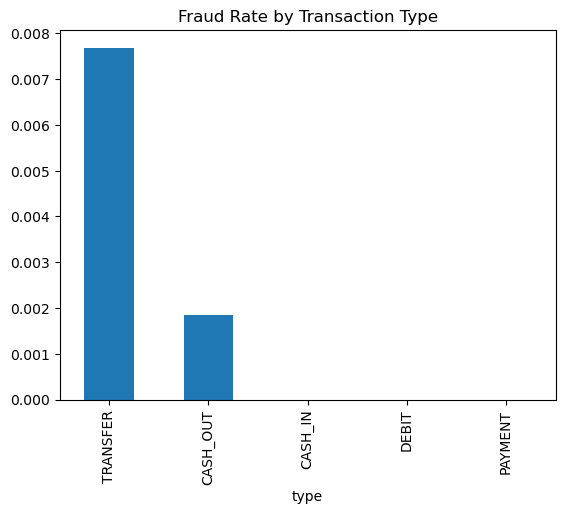

In [8]:
# Fraud rate by type
fraud_rate = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
print("\nFraud rate by type:\n", fraud_rate)
fraud_rate.plot(kind='bar', title='Fraud Rate by Transaction Type'); plt.show()


We can notice that most of the frauds are occured in TRANSFER and CASH_OUT


# Feature Engineering 

In [9]:
#Creating new coloumns 

#Checking error in balance for inconsistencies 

df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

#Dropping raw amount columns 

df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'],axis=1,inplace=True)



In [10]:
df.head()

df.shape

(6362620, 7)

In [11]:
#Dealing with outliers 

#Using Z-score 

df["Z-Score"] = (df["errorBalanceDest"] - df["errorBalanceDest"].mean())/df["errorBalanceDest"].std()

print(df["Z-Score"])



0           0.103566
1           0.121629
2           0.125442
3           0.077468
4           0.099425
             ...    
6362615     0.125852
6362616   -14.168595
6362617     0.125852
6362618    -1.799283
6362619     0.125852
Name: Z-Score, Length: 6362620, dtype: float64


In [12]:
mean = df["errorBalanceDest"].mean()

SD = df["errorBalanceDest"].std()

Highest = mean + 3*SD 

Lowest = mean - 3*SD


In [13]:
df = df[(df["errorBalanceDest"] > Lowest) & (df["errorBalanceDest"] < Highest)]

In [14]:
df.drop(['Z-Score'],axis=1)

,step,type,amount,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
0,1,PAYMENT,9839.64,0,0,1.455192e-11,-9.839640e+03
1,1,PAYMENT,1864.28,0,0,-1.136868e-12,-1.864280e+03
2,1,TRANSFER,181.00,1,0,0.000000e+00,-1.810000e+02
3,1,CASH_OUT,181.00,1,0,0.000000e+00,-2.136300e+04
4,1,PAYMENT,11668.14,0,0,0.000000e+00,-1.166814e+04
...,...,...,...,...,...,...,...
6362614,743,TRANSFER,339682.13,1,0,0.000000e+00,-3.396821e+05
6362615,743,CASH_OUT,339682.13,1,0,0.000000e+00,0.000000e+00
6362617,743,CASH_OUT,6311409.28,1,0,0.000000e+00,-1.000000e-02
6362618,743,TRANSFER,850002.52,1,0,0.000000e+00,-8.500025e+05


In [15]:
#Seperate Features and Target 

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']


# Coloumn Transformers and model Training 

In [16]:
numeric_cols     = ['step', 'amount', 'errorBalanceOrig', 'errorBalanceDest']
categorical_cols = ['type']
 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


In [17]:
#Train,test split the data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)


In [18]:
X_train

,step,type,amount,errorBalanceOrig,errorBalanceDest,Z-Score
6076915,518,CASH_OUT,44731.21,-4.473121e+04,-3.637979e-11,0.125852
3977175,297,CASH_OUT,132752.41,-1.327524e+05,-8.731149e-11,0.125852
5513842,380,PAYMENT,3682.58,0.000000e+00,-3.682580e+03,0.117511
754065,38,PAYMENT,5969.39,-9.094947e-13,-5.969390e+03,0.112332
1289600,135,PAYMENT,59748.48,7.275958e-12,-5.974848e+04,-0.009470
...,...,...,...,...,...,...
4907382,349,PAYMENT,17303.18,-7.725180e+03,-1.730318e+04,0.086663
2757965,212,TRANSFER,272883.57,-2.585401e+05,5.820766e-11,0.125852
3080625,235,CASH_OUT,91792.24,-9.179224e+04,-1.455192e-11,0.125852
2325707,188,CASH_OUT,173110.93,-1.232879e+05,0.000000e+00,0.125852


In [19]:
y_test

3860431    0
711203     0
2652557    0
4795296    0
5396128    0
          ..
2995767    0
1417804    0
5896907    0
3789668    0
5669361    0
Name: isFraud, Length: 1268802, dtype: int64

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first'), categorical_cols),
        ('scaler', StandardScaler(),numeric_cols)
    ]
)

In [21]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)


In [22]:
X_train_processed 

array([[ 1.        ,  0.        ,  0.        , ..., -0.23317217,
         0.26897622,  0.36029966],
       [ 1.        ,  0.        ,  0.        , ..., -0.07445617,
         0.11236118,  0.36029966],
       [ 0.        ,  0.        ,  1.        , ..., -0.30718928,
         0.34856591,  0.34002625],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.14831377,
         0.18524111,  0.36029966],
       [ 1.        ,  0.        ,  0.        , ..., -0.00168344,
         0.12920121,  0.36029966],
       [ 1.        ,  0.        ,  0.        , ...,  0.29902522,
        -0.25617635,  0.36029966]])

In [23]:
from sklearn.linear_model import LogisticRegression



#Logistic Regression Pipeline 

pipe = Pipeline([
    ("preproc", preprocessor),
    ("clf",     LogisticRegression(class_weight='balanced',
                                   max_iter=1000,
                                   random_state=42))
])




Model Tuning 

In [24]:



from sklearn.model_selection import  RandomizedSearchCV

param_dist = {
    "clf__C":       [0.01, 0.1, 1, 10, 100],
    "clf__solver":  ["liblinear", "lbfgs"],
    "clf__penalty": ["l2"]
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [ ]:
search.fit(X_train, y_train)

best_lr = search.best_estimator_
print("Best hyperparameters:", search.best_params_)

y_pred  = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


In [ ]:

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [ ]:
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.4f}")